In [8]:
import matplotlib.pyplot as plt
import os
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling1D, Dense, Flatten, Activation, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import NASNetLarge
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model

In [50]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
!unzip -q kagglecatsanddogs_3367a.zip
!ls
!ls PetImages

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0  26.9M      0  0:00:29  0:00:29 --:--:-- 28.6M
replace PetImages/Cat/0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C
'MSR-LA - 3467.docx'   __notebook_source__.ipynb     model.png
 PetImages	       kagglecatsanddogs_3367a.zip  'readme[1].txt'
Cat  Dog


In [51]:
num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)
print("Deleted %d images" % num_skipped)

Deleted 0 images


In [52]:
image_size = (128, 128)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Found 23410 files belonging to 2 classes.
Using 4682 files for validation.


In [53]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

In [61]:
class HistoryCallback(keras.callbacks.Callback):
    def __init__(self):
        self.epochs = 0
        self.train_loss = []
        self.train_acc = []
        self.val_loss = []
        self.val_acc = []
        
        %matplotlib inline
        
    def on_epoch_end(self, epoch, logs=None):
        self.epochs += 1
        self.train_loss.append(logs['loss'])
        self.train_acc.append(logs['acc'])
        self.val_loss.append(logs['val_loss'])
        self.val_acc.append(logs['val_acc'])
        
    def on_train_end(self, epoch, logs=None):
        self.plot()
        
    def plot(self):
        fig, ax = plt.subplots(1,2, figsize=(10,5))
        
        ax[0].plot(self.train_loss, label='train loss')
        ax[0].plot(self.val_loss, label='val loss')
        ax[0].legend()
        ax[1].plot(self.train_acc, label='train acc')
        ax[1].plot(self.val_acc, label='val acc')
        ax[1].legend()
        plt.show()

In [62]:
num_classes = 1
input_shape = (128, 128, 3)

In [63]:
data_augmentation = keras.Sequential(
    [
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

In [66]:
batch_size = 32
epochs = 10

models = [MobileNet,ResNet50,DenseNet121,Xception,MobileNetV2]

def mod(models, train, valid):
    '''Функция принимает на вход различные модели и на выходе показвает предсказания валидации '''
    
    for mod in models:
        try_model = mod(weights='imagenet', include_top=False)
        
        x = try_model.output
        x = GlobalAveragePooling2D()(x)
        x = Dense(512, activation='relu')(x)
        predictions = Dense(1, activation='sigmoid')(x)
        
        model = Model(inputs=try_model.input, outputs=predictions)
        
        parth = int(len(model.layers)*0.7)
        
        for layer in try_model.layers[:parth]:
            layer.trainable = False
            
        for layer in try_model.layers[parth+1:]:
            layer.trainable = True
            
        model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss='binary_crossentropy',metrics='acc')
        
        print(mod, '\n')
        print(model.fit(train, batch_size=batch_size, epochs=epochs, validation_data=valid),'\n')

In [67]:
mod(models,train_ds,val_ds)

<function MobileNet at 0x7f84fdc98ef0> 

Epoch 1/10
586/586 [==============================] - 37s 59ms/step - loss: 0.8473 - acc: 0.7339 - val_loss: 0.5581 - val_acc: 0.8091
Epoch 2/10
586/586 [==============================] - 34s 57ms/step - loss: 0.3749 - acc: 0.8302 - val_loss: 0.4500 - val_acc: 0.8082
Epoch 3/10
586/586 [==============================] - 34s 57ms/step - loss: 0.3306 - acc: 0.8545 - val_loss: 0.4496 - val_acc: 0.8210
Epoch 4/10
586/586 [==============================] - 34s 57ms/step - loss: 0.2982 - acc: 0.8709 - val_loss: 1.1518 - val_acc: 0.6628
Epoch 5/10
586/586 [==============================] - 34s 57ms/step - loss: 0.2648 - acc: 0.8873 - val_loss: 0.4354 - val_acc: 0.8266
Epoch 6/10
586/586 [==============================] - 34s 57ms/step - loss: 0.2449 - acc: 0.8974 - val_loss: 0.5352 - val_acc: 0.8120
Epoch 7/10
586/586 [==============================] - 35s 59ms/step - loss: 0.2098 - acc: 0.9106 - val_loss: 1.5378 - val_acc: 0.7324
Epoch 8/10
586/586 [=

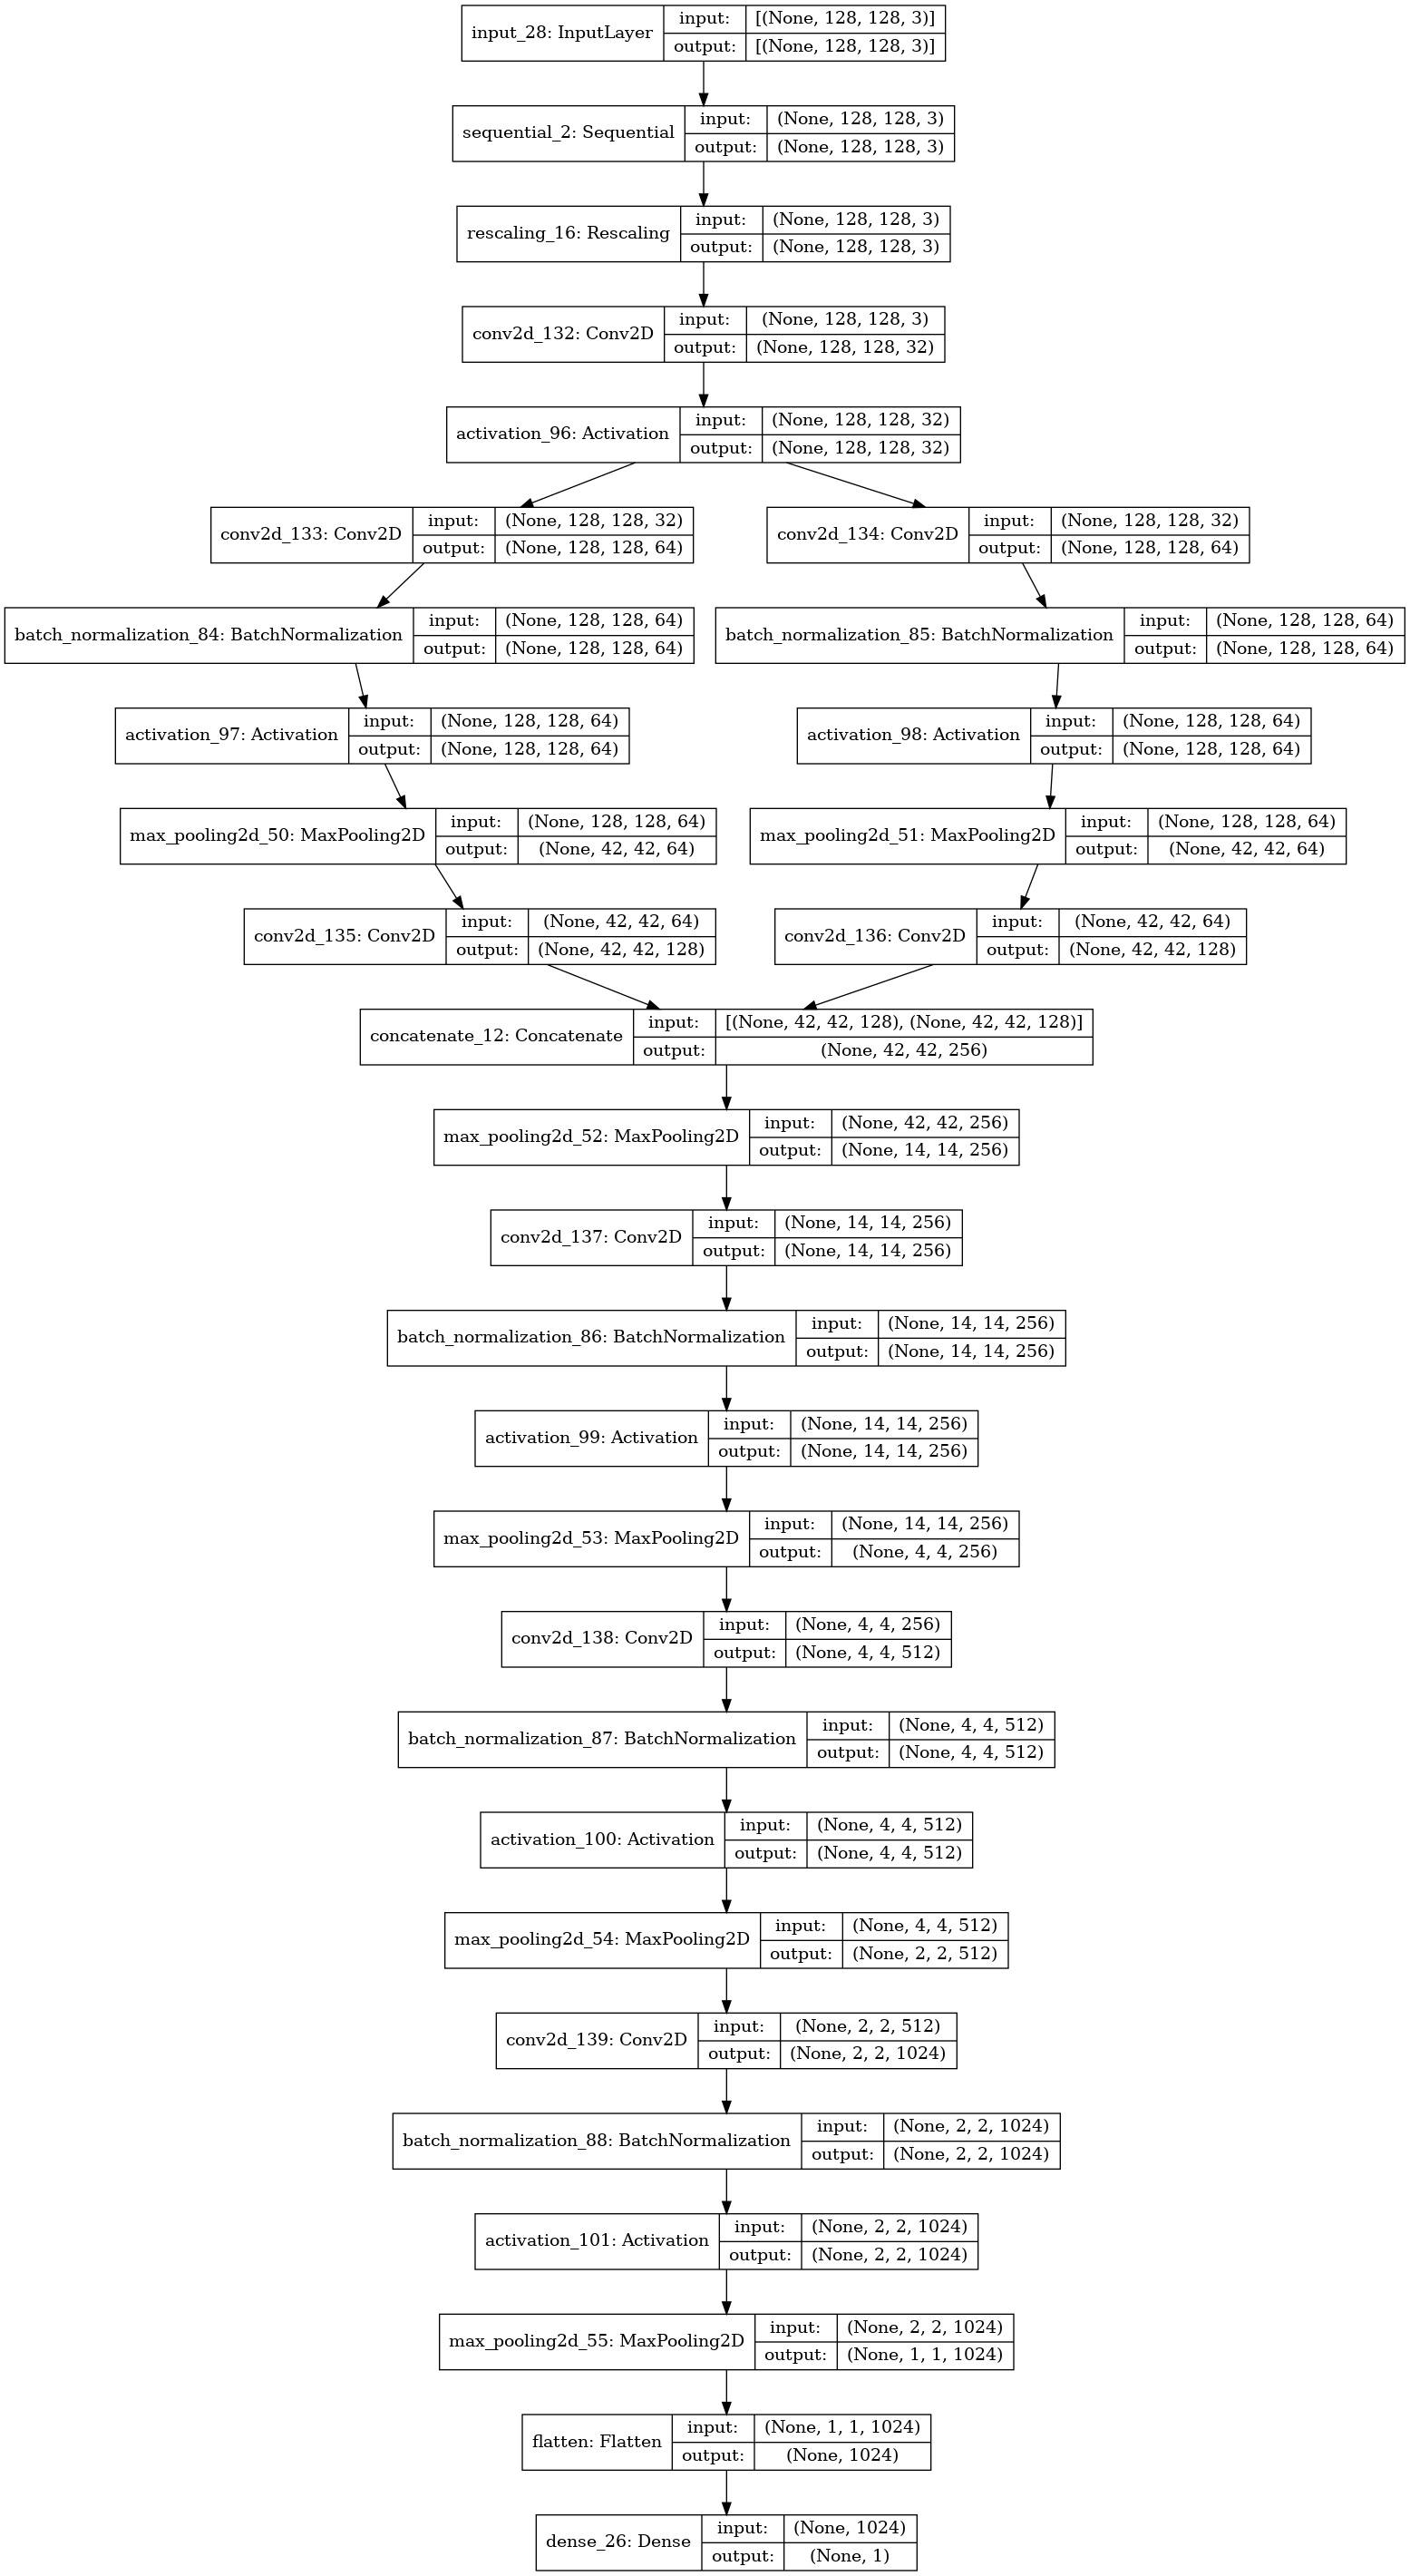

In [68]:
def Net ():
    inputs = keras.Input(shape=input_shape)
    dense_1 = data_augmentation(inputs)
    dense_1 = tf.keras.layers.experimental.preprocessing.Rescaling(1.0/255)(dense_1)
    dense_1 = layers.Conv2D(32, 3, strides=1, padding='same')(dense_1)
    dense_1 = layers.Activation('relu')(dense_1)
    
    dense_common = layers.Conv2D(64, 3, padding='same')(dense_1)  
    
    dense_2 = layers.BatchNormalization()(dense_common)
    dense_2 = layers.Activation('relu')(dense_2)
    dense_2 = layers.MaxPooling2D(3)(dense_2)
    dense_2 = layers.Conv2D(128, 3, padding='same')(dense_2)
    
    dense_3 = layers.BatchNormalization()(dense_common)
    dense_3 = layers.Activation('relu')(dense_3)
    dense_3 = layers.MaxPooling2D(3)(dense_3)  
    dense_3 = layers.Conv2D(128, 3, padding='same')(dense_3)
    
    dense_4 = layers.Concatenate(axis=-1)([dense_2,dense_3])
    dense_4 = layers.MaxPooling2D(3)(dense_4)
    dense_4 = layers.Conv2D(256,3,padding='same')(dense_4)
    dense_4 = layers.BatchNormalization()(dense_4)
    dense_4 = layers.Activation('relu')(dense_4)
    
    dense_4 = layers.MaxPooling2D(3)(dense_4)
    dense_4 = layers.Conv2D(512,3,padding='same')(dense_4)
    dense_4 = layers.BatchNormalization()(dense_4)
    dense_4 = layers.Activation('relu')(dense_4)
    
    dense_4 = layers.MaxPooling2D(2)(dense_4)
    dense_4 = layers.Conv2D(1024,3,padding='same')(dense_4)
    dense_4 = layers.BatchNormalization()(dense_4)
    dense_4 = layers.Activation('relu')(dense_4)   
    
    dense_4 = layers.MaxPooling2D(2)(dense_4)
    dense_4 = layers.Flatten()(dense_4)
    
    outputs = layers.Dense(1, activation = 'sigmoid')(dense_4)
    return keras.Model(inputs, outputs)
model = Net()
keras.utils.plot_model(model, show_shapes=True)

In [69]:
model.summary()

Model: "model_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_28 (InputLayer)           [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 128, 128, 3)  0           input_28[0][0]                   
__________________________________________________________________________________________________
rescaling_16 (Rescaling)        (None, 128, 128, 3)  0           sequential_2[0][0]               
__________________________________________________________________________________________________
conv2d_132 (Conv2D)             (None, 128, 128, 32) 896         rescaling_16[0][0]               
___________________________________________________________________________________________

In [70]:
history = HistoryCallback()
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", # по какому параметру будем останавливать
    patience=10, # сколько эпох подряд качество не должно улучшаться для остановки
    restore_best_weights=False # также можно восстанавливать лучшие веса после остановки (откатываться на 5 эпох назад)
)
model.compile(loss="binary_crossentropy", 
              optimizer=Adam(learning_rate=0.005), 
              metrics='acc')

Epoch 1/15
586/586 [==============================] - 44s 72ms/step - loss: 0.8210 - acc: 0.5914 - val_loss: 0.6164 - val_acc: 0.6696
Epoch 2/15
586/586 [==============================] - 43s 72ms/step - loss: 0.5834 - acc: 0.6979 - val_loss: 0.5195 - val_acc: 0.7454
Epoch 3/15
586/586 [==============================] - 43s 72ms/step - loss: 0.4784 - acc: 0.7718 - val_loss: 0.4999 - val_acc: 0.7527
Epoch 4/15
586/586 [==============================] - 42s 71ms/step - loss: 0.3937 - acc: 0.8203 - val_loss: 0.4179 - val_acc: 0.8026
Epoch 5/15
586/586 [==============================] - 41s 70ms/step - loss: 0.3243 - acc: 0.8585 - val_loss: 0.2617 - val_acc: 0.8853
Epoch 6/15
586/586 [==============================] - 42s 71ms/step - loss: 0.2839 - acc: 0.8809 - val_loss: 0.2797 - val_acc: 0.8759
Epoch 7/15
586/586 [==============================] - 41s 70ms/step - loss: 0.2510 - acc: 0.8949 - val_loss: 0.6053 - val_acc: 0.7599
Epoch 8/15
586/586 [==============================] - 41s 69ms

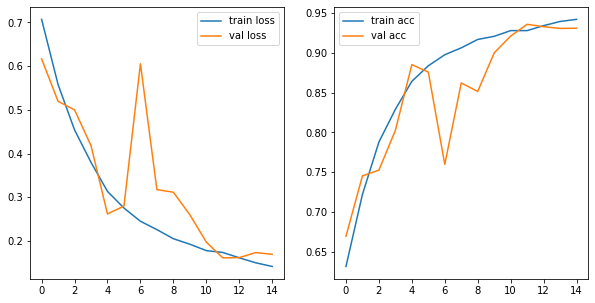

In [71]:
model.fit(train_ds, batch_size=batch_size, epochs=epochs+5, validation_data=val_ds, callbacks=[history, early_stopping],verbose=1,use_multiprocessing=True)

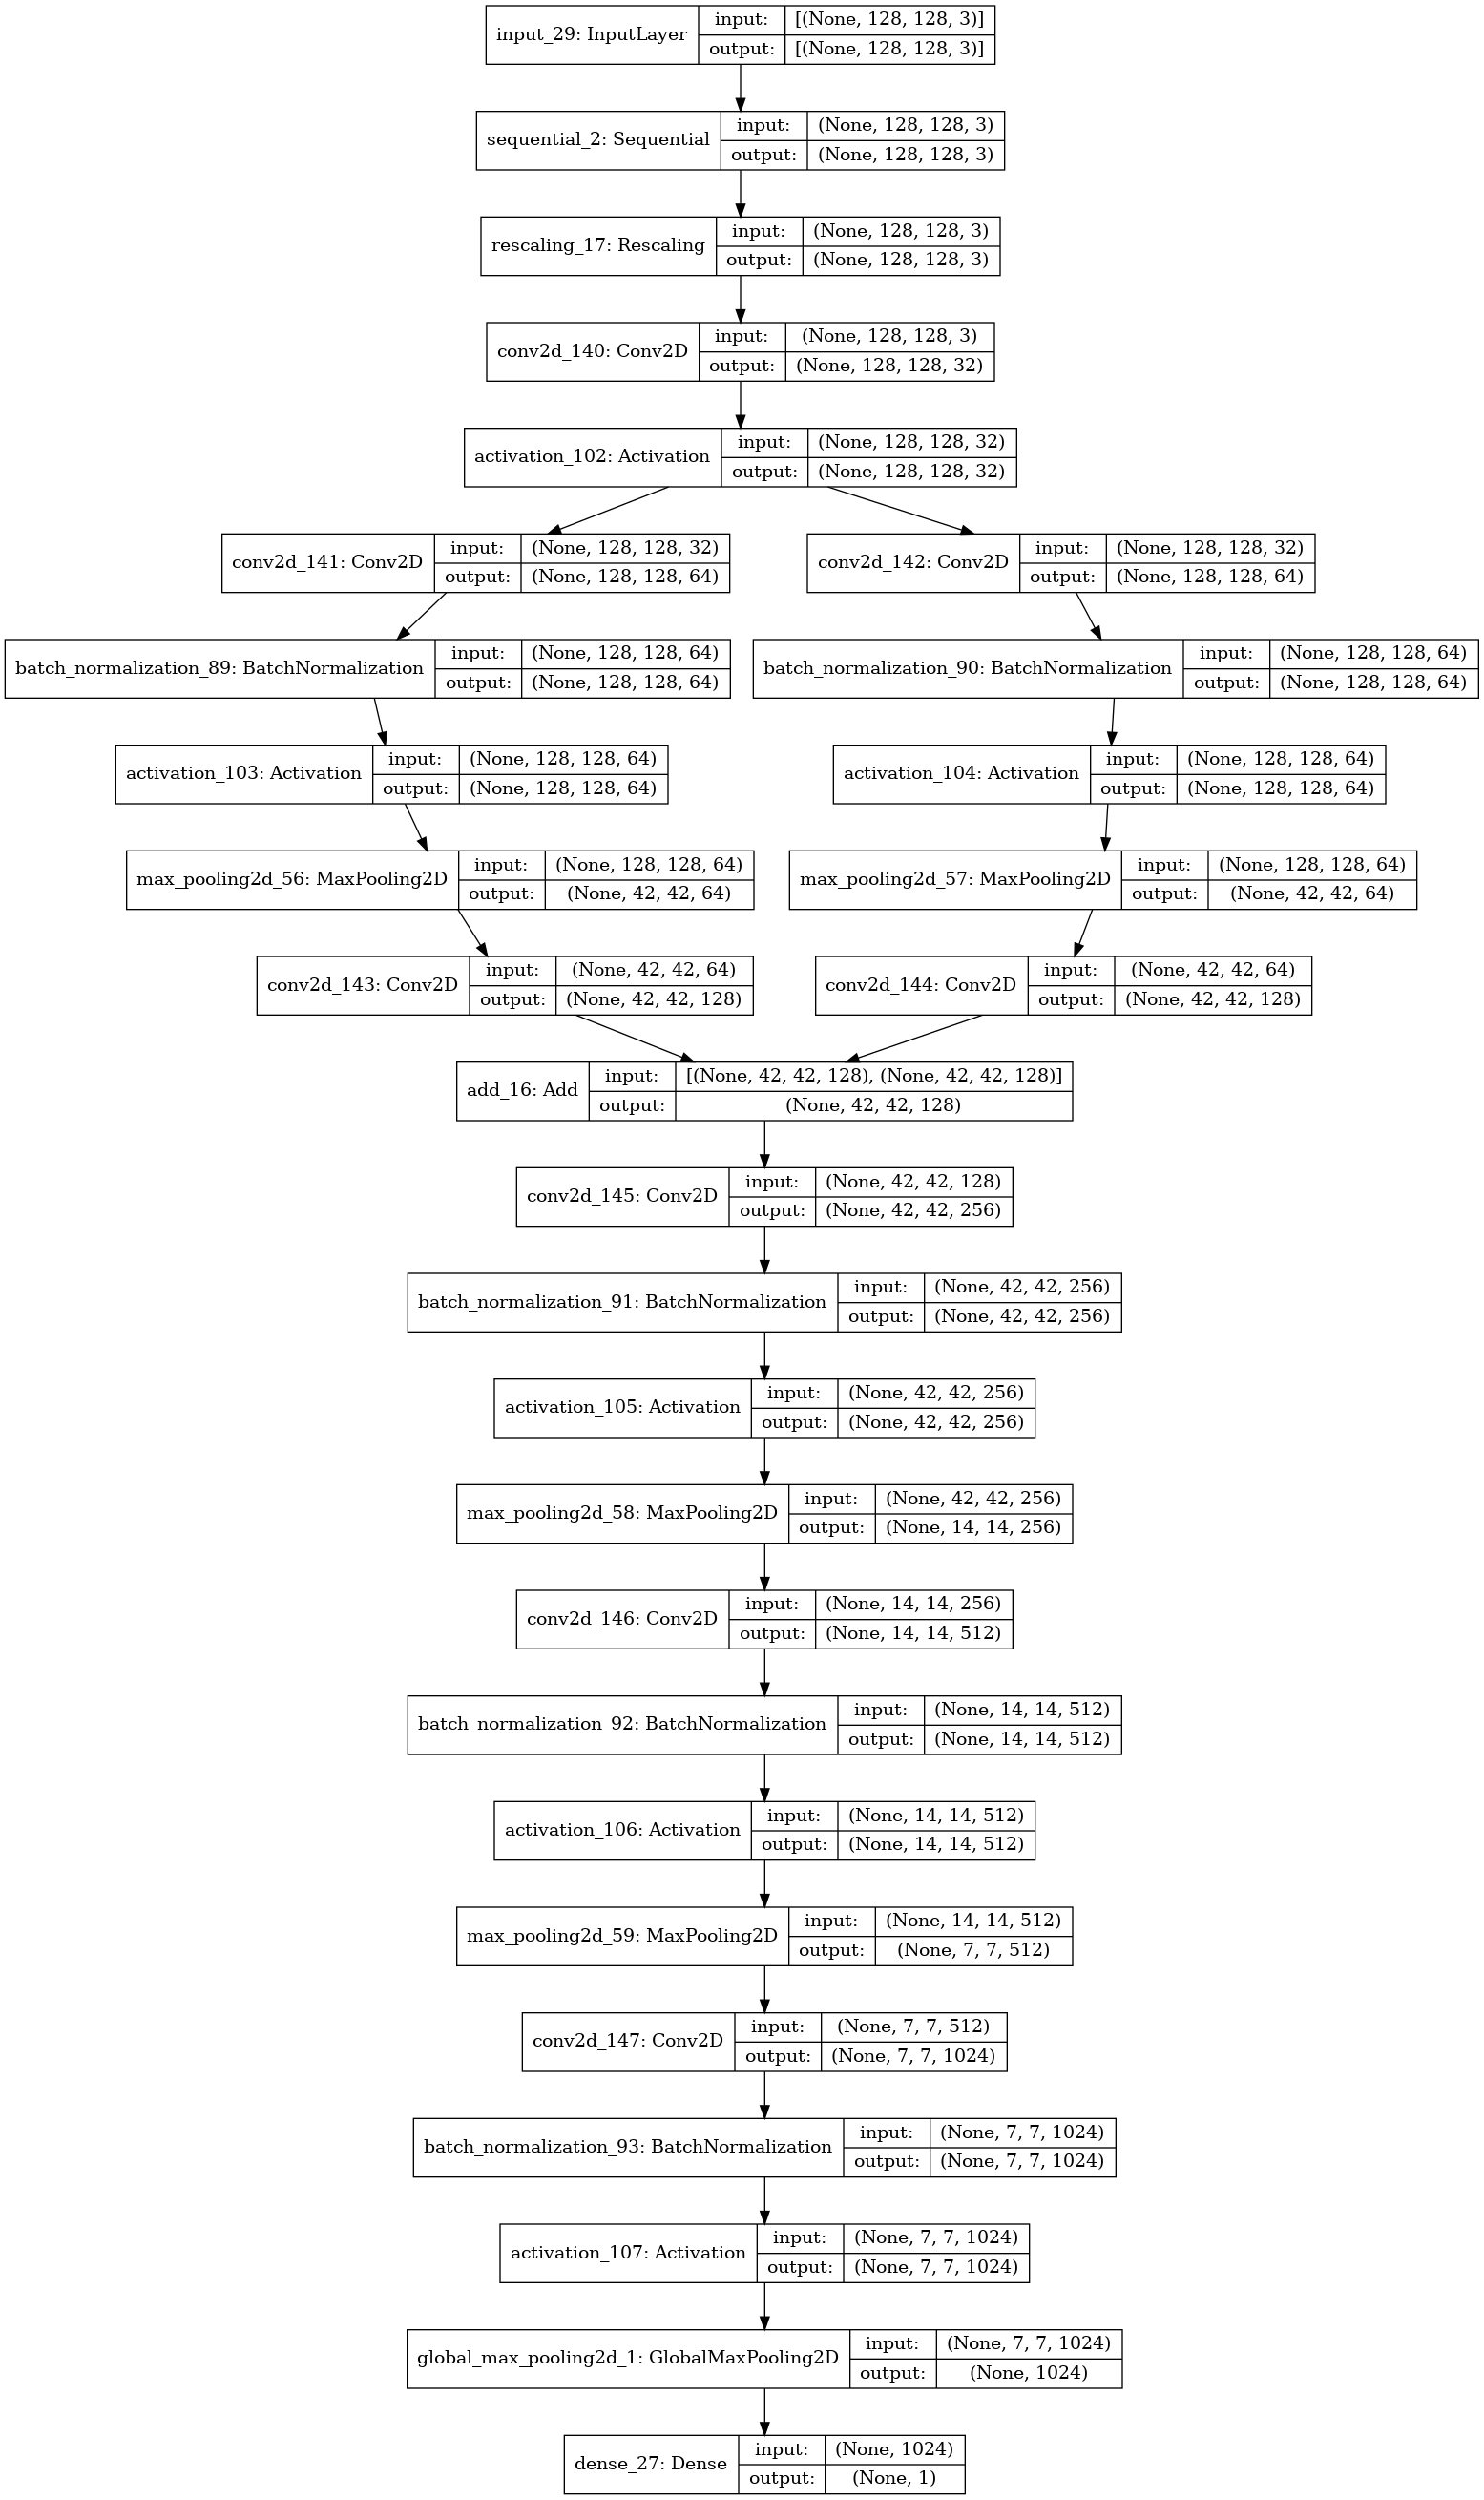

In [72]:
def Net ():
    model = keras.Sequential
    inputs = keras.Input(shape=input_shape)
    dense_1 = data_augmentation(inputs)
    dense_1 = tf.keras.layers.experimental.preprocessing.Rescaling(1.0/255)(dense_1)
    dense_1 = layers.Conv2D(32, 3, strides=1, padding='same')(dense_1)
    dense_1 = layers.Activation('relu')(dense_1)
    
    dense_common = layers.Conv2D(64, 3, padding='same')(dense_1) 
    
    dense_2 = layers.BatchNormalization()(dense_common)
    dense_2 = layers.Activation('relu')(dense_2)
    dense_2 = layers.MaxPooling2D(3)(dense_2)
    dense_2 = layers.Conv2D(128, 3, padding='same')(dense_2)
    
    dense_3 = layers.BatchNormalization()(dense_common)
    dense_3 = layers.Activation('relu')(dense_3)
    dense_3 = layers.MaxPooling2D(3)(dense_3)  
    dense_3 = layers.Conv2D(128, 3, padding='same')(dense_3)
    
    dense_4 = layers.add([dense_2,dense_3])
    dense_4 = layers.Conv2D(256,3,padding='same')(dense_4)
    dense_4 = layers.BatchNormalization()(dense_4)
    dense_4 = layers.Activation('relu')(dense_4)
    
    dense_4 = layers.MaxPooling2D(3)(dense_4)
    dense_4 = layers.Conv2D(512,3,padding='same')(dense_4)
    dense_4 = layers.BatchNormalization()(dense_4)
    dense_4 = layers.Activation('relu')(dense_4)
    
    dense_4 = layers.MaxPooling2D(2)(dense_4)
    dense_4 = layers.Conv2D(1024,3,padding='same')(dense_4)
    dense_4 = layers.BatchNormalization()(dense_4)
    dense_4 = layers.Activation('relu')(dense_4)   
    
    dense_4 = layers.GlobalMaxPooling2D()(dense_4)
#     dense_4 = layers.Flatten()(dense_4)
    
    outputs = layers.Dense(1, activation = 'sigmoid')(dense_4)
    return keras.Model(inputs, outputs)
model = Net()
keras.utils.plot_model(model, show_shapes=True)

In [73]:
model.summary()

Model: "model_18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_29 (InputLayer)           [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 128, 128, 3)  0           input_29[0][0]                   
__________________________________________________________________________________________________
rescaling_17 (Rescaling)        (None, 128, 128, 3)  0           sequential_2[1][0]               
__________________________________________________________________________________________________
conv2d_140 (Conv2D)             (None, 128, 128, 32) 896         rescaling_17[0][0]               
___________________________________________________________________________________________

In [74]:
history = HistoryCallback()
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", # по какому параметру будем останавливать
    patience=10, # сколько эпох подряд качество не должно улучшаться для остановки
    restore_best_weights=False # также можно восстанавливать лучшие веса после остановки (откатываться на 5 эпох назад)
)
model.compile(loss="binary_crossentropy", 
              optimizer=Adam(learning_rate=0.01), 
              metrics='acc')

Epoch 1/15
586/586 [==============================] - 45s 74ms/step - loss: 1.1168 - acc: 0.5445 - val_loss: 0.8900 - val_acc: 0.5624
Epoch 2/15
586/586 [==============================] - 43s 74ms/step - loss: 0.7037 - acc: 0.6019 - val_loss: 0.6299 - val_acc: 0.6213
Epoch 3/15
586/586 [==============================] - 44s 75ms/step - loss: 0.5980 - acc: 0.6893 - val_loss: 0.7056 - val_acc: 0.6070
Epoch 4/15
586/586 [==============================] - 43s 73ms/step - loss: 0.4835 - acc: 0.7688 - val_loss: 0.3981 - val_acc: 0.8170
Epoch 5/15
586/586 [==============================] - 43s 73ms/step - loss: 0.3642 - acc: 0.8365 - val_loss: 0.2960 - val_acc: 0.8686
Epoch 6/15
586/586 [==============================] - 44s 75ms/step - loss: 0.2905 - acc: 0.8724 - val_loss: 0.4475 - val_acc: 0.7845
Epoch 7/15
586/586 [==============================] - 44s 74ms/step - loss: 0.2582 - acc: 0.8873 - val_loss: 0.2795 - val_acc: 0.8798
Epoch 8/15
586/586 [==============================] - 43s 73ms

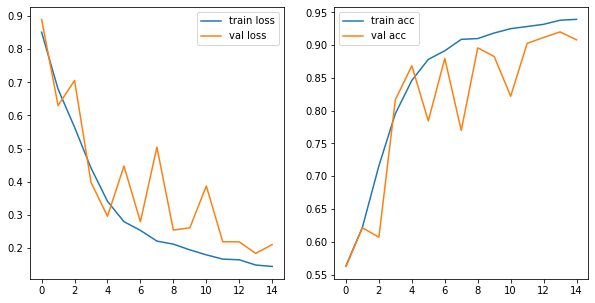

In [75]:
model.fit(train_ds, batch_size=batch_size, epochs=epochs+5, validation_data=val_ds, callbacks=[history, early_stopping],verbose=1,use_multiprocessing=True)